<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-и-обзор-данных" data-toc-modified-id="Загрузка-и-обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и обзор данных</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Подготовка-к-МО" data-toc-modified-id="Подготовка-к-МО-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка к МО</a></span><ul class="toc-item"><li><span><a href="#Определение-и-добавление-факторов,-введение-функций" data-toc-modified-id="Определение-и-добавление-факторов,-введение-функций-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Определение и добавление факторов, введение функций</a></span></li></ul></li><li><span><a href="#Обучение-моделей-МО" data-toc-modified-id="Обучение-моделей-МО-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение моделей МО</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Неободимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель исследования:** 
1. Создание модели машинного обучения предсказания количества заказов такси в аэропорту в следующие часы.

**Задачи исследования:**
1. Предобработать данные
2. Разделить данные на выборки (обучающая и тестовая, признаки и целевой показатель)
3. Проверить модели машинного обучения на данных
4. Сравненить результаты моделей по метрике RMSE.

**Объектом исследования** являются данные о заказах такси в аэропорту.

**Предметом исследования** является комплекс методик машинного обучения и инструментов связанных с МО.


## Импорт библиотек

Устанавливаем и импортируем необходимое

In [1]:
!pip install lightgbm
!pip install ydata-profiling
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import time

from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import lightgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
SIZE = (20,5)

## Загрузка и обзор данных

In [4]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
print('Данные последовательны' if data.index.is_monotonic == True else 'Данные не последовательны')

Данные последовательны


**Вывод:** Данные в порядке, монотонность сохранена, нули в данных обоснованы отсутствием заказов такси в определенные 10 минут. Предобработка данных не требуется. Имеются данные с марта по август(включительно), 2018 год

## Подготовка

### Ресемплирование

Сконсолидируем данные по часу, нам нужно суммарное количество заказов каждый час.

In [7]:
data = data.resample('1H').sum()

In [8]:
data.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

In [9]:
data.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

## Анализ

Посмотрим график количества заказов по времени за весь период, за март, август и последнюю неделю августа

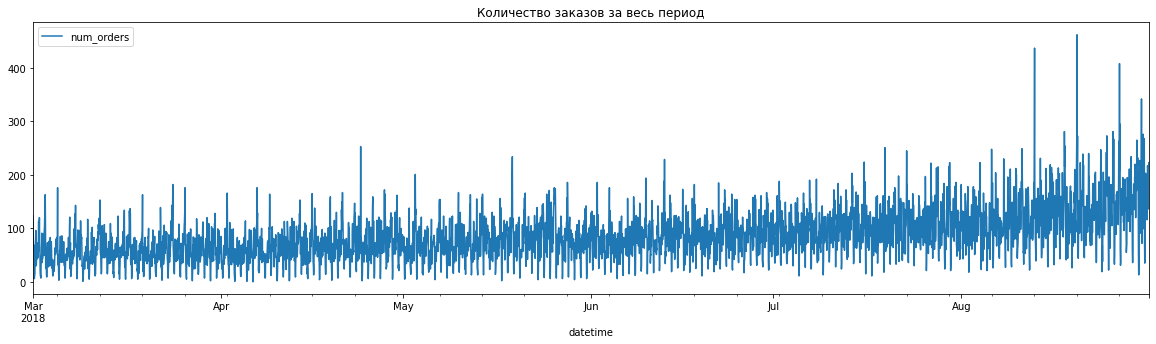

In [10]:
data.plot(figsize=SIZE, title = 'Количество заказов за весь период');

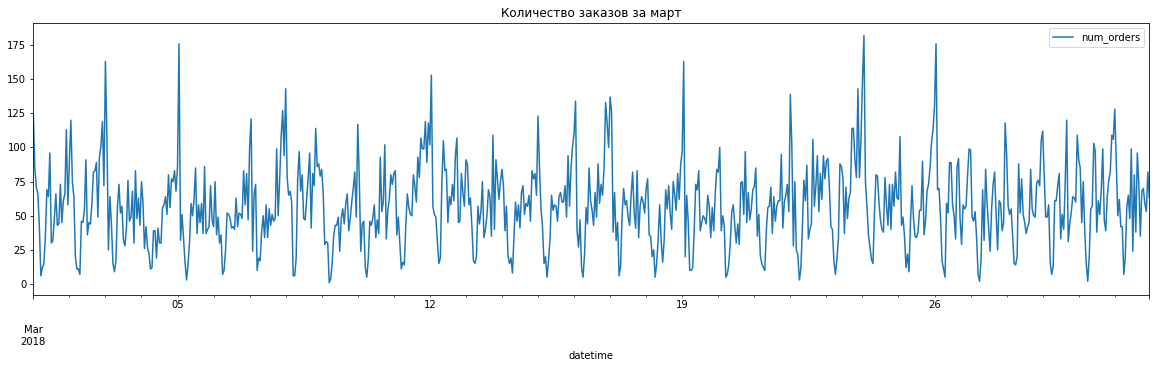

In [11]:
data['2018-03':'2018-03'].plot(figsize=SIZE, title = 'Количество заказов за март');

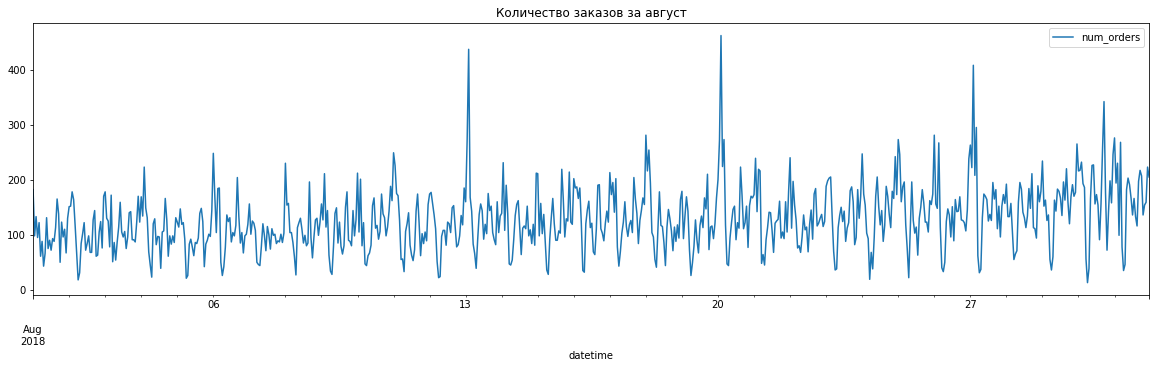

In [12]:
data['2018-08':'2018-08'].plot(figsize= SIZE, title = 'Количество заказов за август');

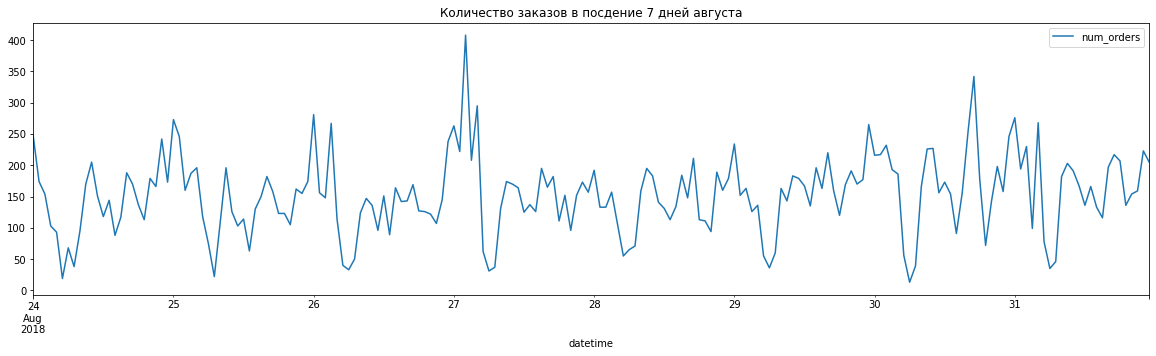

In [13]:
data['2018-08-24':'2018-08-31'].plot(figsize= SIZE, title = 'Количество заказов в посдение 7 дней августа');

Видим явно выраженную сезонность(Предполагается **дневная сезонность и недельная**), проверим специальным методом `seasonal_decompose`, разложим на тренд, сазонность и остатки

In [14]:
decomposed = seasonal_decompose(data)

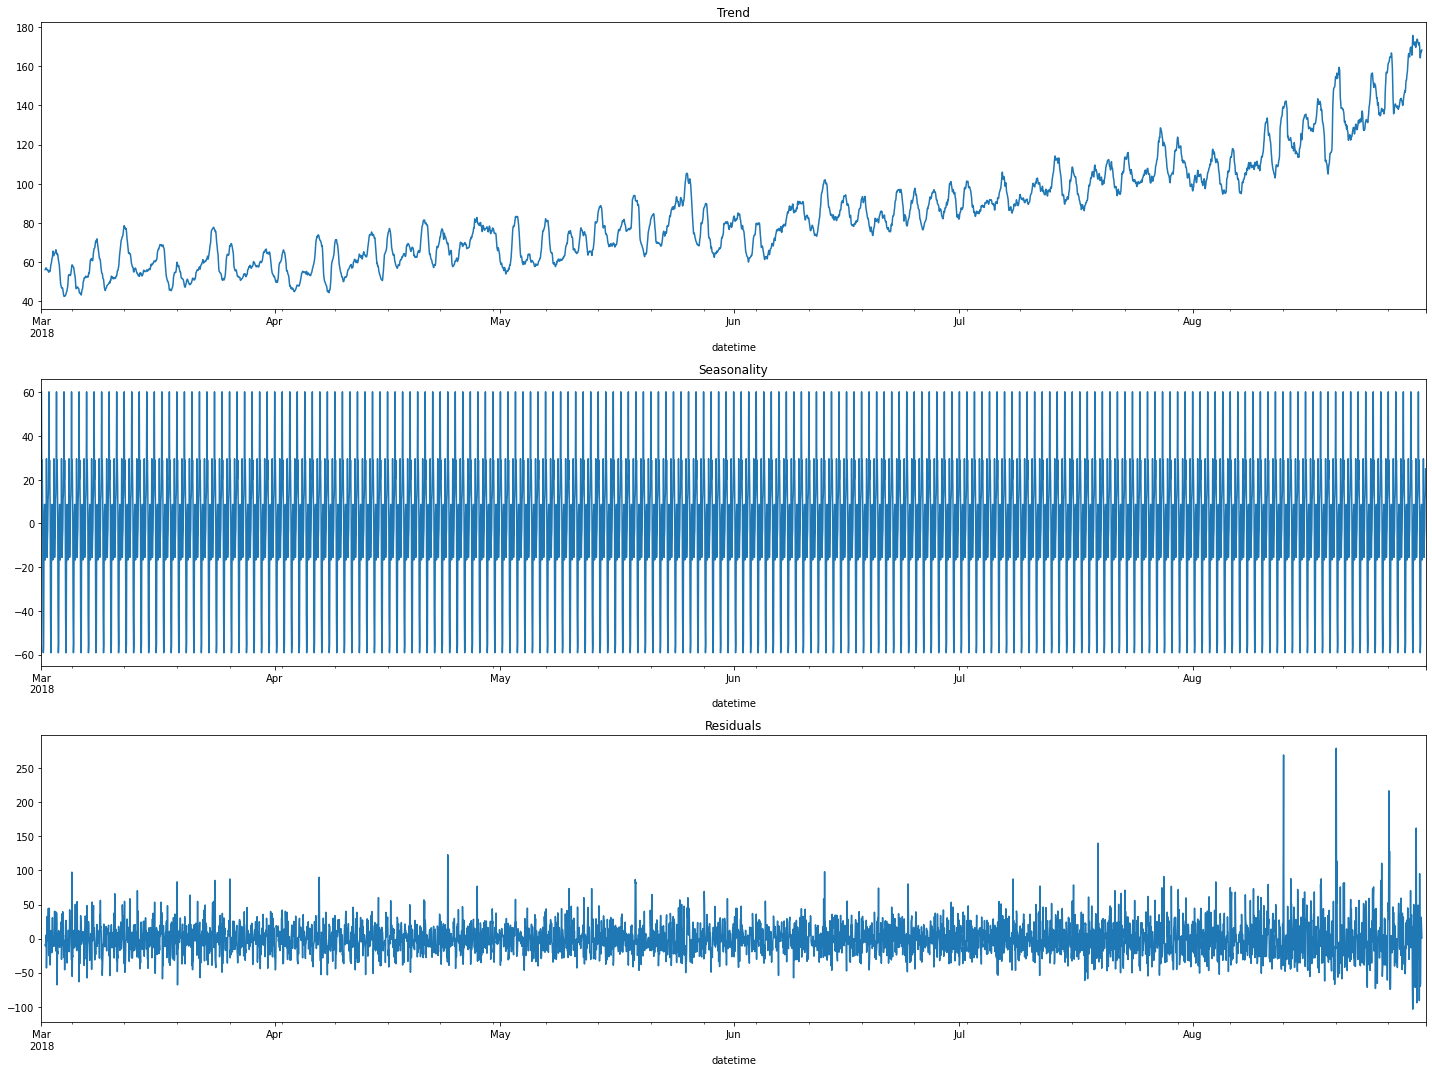

In [15]:
plt.figure(figsize=(20, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Четко видим растущий тренд, ежедневную сезонность и малое количество остатков, которые растут к концу периода

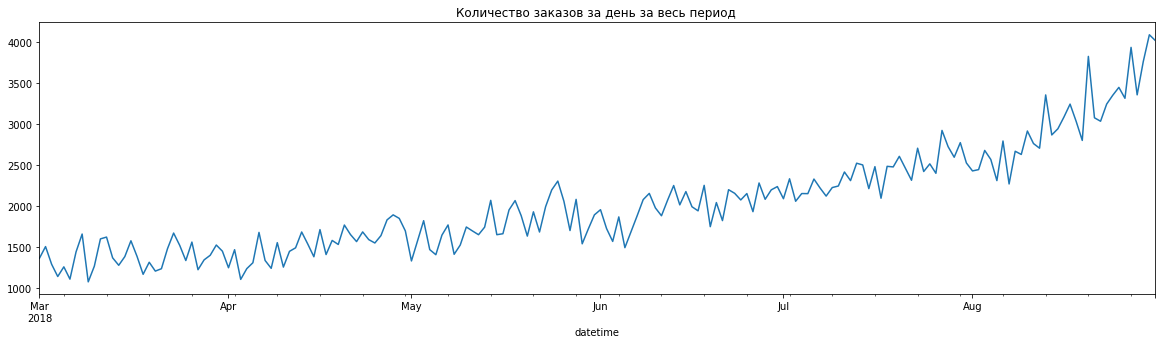

In [16]:
data['num_orders'].resample('1D').sum().plot(figsize= SIZE, title = 'Количество заказов за день за весь период ');

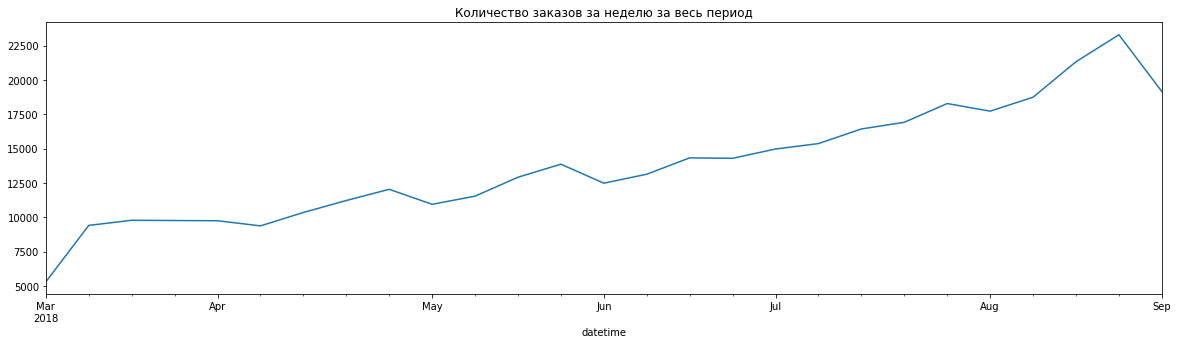

In [17]:
data['num_orders'].resample('1W').sum().plot(figsize= SIZE, title = 'Количество заказов за неделю за весь период');

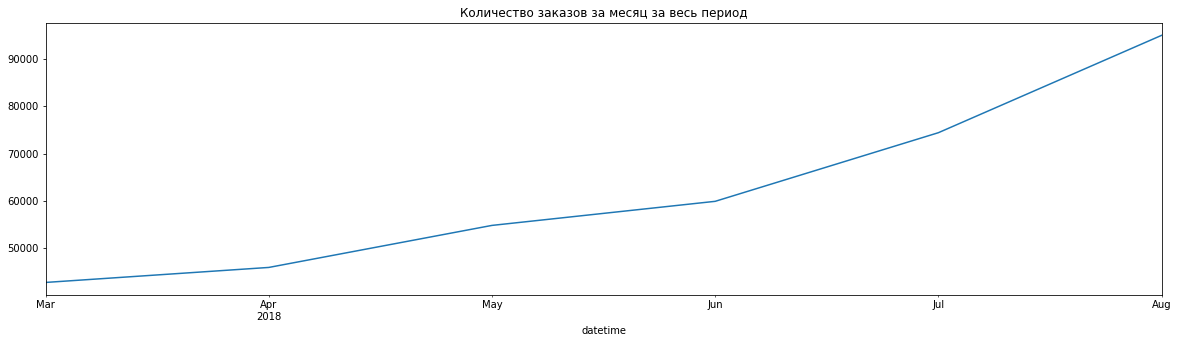

In [18]:
data['num_orders'].resample('1M').sum().plot(figsize= SIZE, title = 'Количество заказов за месяц за весь период');

Консолидация(ресемплирование) данных по дню, неделе и месяцу так же дает понять, что имеется общий тренд на увеличение числа заказов такси.

## Подготовка к МО

### Определение и добавление факторов, введение функций

В первую очередь добавим данные о тренде, сезонной составляющей и остатках(на всякий случай) со сдвигом на 1 день (24 часа) в нашу исходную таблицу, т.к. надлюдается **ежедневная** сезонность

In [19]:
data['trend_lag24'] = seasonal_decompose(data['num_orders']).trend.shift(24)
data['seasonal_lag24'] = seasonal_decompose(data['num_orders']).seasonal.shift(24)
data['resid_lag24'] = seasonal_decompose(data['num_orders']).resid.shift(24)
data.isna().sum()

num_orders         0
trend_lag24       36
seasonal_lag24    24
resid_lag24       36
dtype: int64

Введем функцию добавления факторов сдвигов и скользящей средней(и номеров дня, месяца и дня недели), функцию разделения на выборки и масштабирования

In [20]:
def make_features(data, lag_list, roll_list):
    '''
    Функция принимает датасет с времянным рядом, 
    список необходимых сдвигов 
    и список неободимых скользящих средних
    '''
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in lag_list:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    for roll in roll_list:
        data['roll_{}'.format(roll)] = data['num_orders'].shift(1).rolling(roll).mean()
    print('факторы добавлены')
    print(data.columns)
    return data

In [21]:
def split(data):
    '''
    Создаем функцию разделения датасета на выборки и проверки их размеров
    '''
    train, data1 = train_test_split(data, shuffle=False, test_size=0.2)
    valid, test = train_test_split(data1, shuffle=False, test_size=0.5)
    train = train.dropna()

    features_train = train.drop('num_orders',axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop('num_orders',axis=1)
    target_valid = valid['num_orders']
    features_test = test.drop('num_orders',axis=1)
    target_test = test['num_orders']
    print('Данные разделены на выборки')
    print(features_train.shape)
    print(features_train.head(1).index)
    print(features_train.tail(1).index)
    print(target_train.shape)
    print(features_valid.shape)
    print(features_valid.head(1).index)
    print(features_valid.tail(1).index)
    print(target_valid.shape)
    print(features_test.head(1).index)
    print(features_test.tail(1).index)
    print(features_test.shape)
    print(target_test.shape)
    return features_train, target_train, features_valid, target_valid, features_test, target_test

## Обучение моделей МО

Применим наши фанкции. Тут стоит пояснить выбор сдвигов: во первых необходимо проверять сколько заказов было 1,2 часа назад, пол дня, и главное сутки назад(именно такая сезонность), дополнительно возьмем сдвиг в 2 дня и неделю, т.к. выходные и все такое. Так же берем скользящее среднее за предыдущие сутки и последние 10 часов.

**Тут стоит быть осторожным, т.к. неправильно подобранные факторы могут сильно ухудшить модель**

In [22]:
data = make_features(data, [1,2,12,24,48,168], [10,24])

факторы добавлены
Index(['num_orders', 'trend_lag24', 'seasonal_lag24', 'resid_lag24',
       'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_12', 'lag_24', 'lag_48',
       'lag_168', 'roll_10', 'roll_24'],
      dtype='object')


In [23]:
features_train, target_train, features_valid, target_valid, features_test, target_test = split(data)

Данные разделены на выборки
(3364, 13)
DatetimeIndex(['2018-03-08'], dtype='datetime64[ns]', name='datetime', freq='H')
DatetimeIndex(['2018-07-26 03:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')
(3364,)
(442, 13)
DatetimeIndex(['2018-07-26 04:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')
DatetimeIndex(['2018-08-13 13:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')
(442,)
DatetimeIndex(['2018-08-13 14:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')
DatetimeIndex(['2018-08-31 23:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')
(442, 13)
(442,)


Проверим на валидационной выборке некоторые модели: константная для проверки(предсказания предыдущими значениями),  линейную, дерево, КатБуст и 

In [24]:
pred_previous = target_test.shift(1).dropna()
mean_squared_error(target_test[1:], pred_previous, squared=False)

58.91761802963282

In [25]:
model = LinearRegression()

model.fit(features_train, target_train)
mean_squared_error(target_valid, model.predict(features_valid), squared=False)

29.0860850748717

In [26]:
model = DecisionTreeRegressor()

model.fit(features_train, target_train)
mean_squared_error(target_valid, model.predict(features_valid), squared=False)

37.975670944835294

In [27]:
%%time
best_model_tree = None
best_result_tree = 60
for d in range(4,15):
    model = DecisionTreeRegressor(
        random_state=12345, max_depth = d)
    model.fit(features_train, target_train)
    result = mean_squared_error(target_valid, model.predict(features_valid), squared=False)
    if result < best_result_tree:
        best_model_tree = model
        best_result_tree = result
print(f'Лучшую точность обеспечивает модель {best_model_tree} - {best_result_tree}')

Лучшую точность обеспечивает модель DecisionTreeRegressor(max_depth=6, random_state=12345) - 32.92730517914869
CPU times: user 285 ms, sys: 0 ns, total: 285 ms
Wall time: 295 ms


In [28]:
%%time
model = CatBoostRegressor(verbose=0)

model.fit(features_train, target_train)
mean_squared_error(target_valid, model.predict(features_valid), squared=False)

CPU times: user 2.89 s, sys: 162 ms, total: 3.06 s
Wall time: 3.84 s


29.70551972935883

In [29]:
%%time
model = LGBMRegressor()

model.fit(features_train, target_train)
mean_squared_error(target_valid, model.predict(features_valid), squared=False)

CPU times: user 10.2 s, sys: 113 ms, total: 10.3 s
Wall time: 10.3 s


29.13057362465431

По первоначальным проверкам моделей без подбора гиперпараметров видим, что хорошие результаты показали линейная регрессия и катбуст, подбор гиперпараметров линейной регрессии обычно к сильным изменениям не приводит, попробуем подобрать гиперпараметры к CatBoostRegressor

In [30]:
%%time
best_model_cat = None
best_result_cat = 100
for iterations in range(100,501,100):
    model = CatBoostRegressor(loss_function='RMSE',iterations=iterations, verbose=0)

    model.fit(features_train, target_train)
    result = mean_squared_error(target_valid, model.predict(features_valid), squared=False)
    if result < best_result_cat:
        best_model_cat = model
        best_result_cat = result
print(f'Лучшую точность обеспечивает модель {best_model_cat} - {best_result_cat}')

Лучшую точность обеспечивает модель <catboost.core.CatBoostRegressor object at 0x7f0fa7acbca0> - 29.308037792159773
CPU times: user 4.49 s, sys: 101 ms, total: 4.6 s
Wall time: 8.06 s


In [31]:
%%time
best_model_cat = None
best_result_cat = 100
for n in range(10,51,10):
    model = CatBoostRegressor(n_estimators=n, verbose=0)

    model.fit(features_train, target_train)
    result = mean_squared_error(target_valid, model.predict(features_valid), squared=False)
    if result < best_result_cat:
        best_model_cat = model
        best_result_cat = result
print(f'Лучшую точность обеспечивает модель {best_model_cat} - {best_result_cat}')

Лучшую точность обеспечивает модель <catboost.core.CatBoostRegressor object at 0x7f10403ab220> - 29.981714171020656
CPU times: user 512 ms, sys: 20 ms, total: 532 ms
Wall time: 3.29 s


Остановимся на линейной регрессии по причине лучшего результата

## Тестирование

Линейная регрессия пока что дает лучший результат

In [32]:
model = LinearRegression()

model.fit(features_train, target_train)
mean_squared_error(target_test, model.predict(features_test), squared=False)

35.37175279223084

Получили необходимый результат: RMSE меньше 48, а именно около 35

## Итоговый вывод

 **1.** Была достигнута цель исследования - выбрана лучшая модель машинного обучения предсказания количества заказов такси в аэропорту в следующий час, для этого было сделано:
1. Загружены данные;
2. Проанализировано количество заказов по часу, дню, недели и месяцу.
3. Выявлена сезонность и тренд.
4. Добавлены факторы (номер дня, месяца, дня недели, сдвигов, скользящих средних)
5. Так же дополнительно промасштабированы признаки
6. Данные были разделены на выборки (train, valid, test);
7. Проверены 4 модели + константная, проверены оптимальные гиперпараметры;
8. Модели протестированы на тестовой выборке.
    
**2.** Лучшие показатели дает **LinearRegression**(без подбора гиперпараметров) **Достигнута целевая метрака RMSE<48** достигнут результат ~35 (29 на валидационной выборке, в отличии от константной модели - 59).